# DeepTCR Tutorial

 

## Introduction

Welcome to DeepTCR! We created DeepTCR to help you analyzie T-Cell Receptor Sequencing (TCRSeq) data in a structurally informed way. The package contains both unsupervised and supervised approaches to analyze your data. In the unsupervised approaches, one can provide your data to the algorithm and learning is done without the use of labels while supervised approaches take advantage of provided labels. While this tutorial will walk you through a cursory analysis of a given dataset, there are many options one can adjust in analyzing their own data. For a comprehensive documentation guide for all methods found in DeepTCR, see the Github repository.


## Preparing Your Data

First, it's important to put your data into a main directory with sub-directories. The main directory reflects the project of data while the subdirectories represent possible groupings of your data. An example of this formatting can be seen in the Data directory provided. Several datasets exist and can be looked for their formatting. If there is no labels for the data, just create one subdirectory with all the files in the folder. The program can either take csv or tsv files (comma,tab delimited files). We will demonstrate how to import either one. 


## Unsupervised Analysis

Unsupervised deep learning approaches are helpful for understanding the structure of TCRSeq data at the sequence level. We have written two methods for sequence data re-representation including a Variational Autoencoder (VAE) and Generative Adversarial Network (GAN). Both methods take sequence data and output numerical vector representations that act as 'featurized' representations of the sequences that can be useful for downstream machine learning and clustering analyses. 

First, we will import a DeepTCR Unsupervised Object for which we will run the methods to do these unsupervised analyses:

In [1]:
%matplotlib inline
from DeepTCR.DeepTCR_U import DeepTCR_U


Create Object with name for analysis. In this case, we will demonstrate the algorithms on the Rudqvist dataset. Besides the name parameter, one can specify the maximum length to allow for sequence. The default is set to 40. Instantiating this object also creates two additional folders, one to store relevant files for the algorithm to run as well as a folder titled Object_Name+_Results/ to store any outputs (i.e. heatmaps) from the analysis.

In [2]:
DTCRU = DeepTCR_U('Rudqvist_U',max_length=40)


First, we will load the data into the object.We simply have to specify the main directory where the data exists. There is also an optional parameter (Load_Prev_Data) which allows us to run this method once and set this to True after to load previously parsed data. Other parameters can be set with details in documentation/README.MD file. Of note, the method can take either csv or tsv files with the default being tsv files. In the case one wants to use csv files, change the sep parameter to ','. Additionally, this method by default uses the column with the word 'acid' for the amino acid sequences and uses the first column with an integer datatype to extract the counts. However, if the data is in different columns, one can specify which columns with the aa_column and counts_column parameters and manually direct the method where to look.

In [3]:
DTCRU.Get_Data(directory='Data/Rudqvist/',Load_Prev_Data=False)


Data Loaded


In order to train the VAE, we need to simply call the command below. We can see below that we specify the reconstruction accuracy to achieve before terminating training as well as the number of latent dimensions to represent the sequence data. One this method is run once, one can load previously learned features by setting the Load_Prev_Data parameter to True. Additionally, we will suppress the output with training statistics to preserve space in the notebook for easier reading. However, normally this parameter is set to False and training statistics are shown to user. 

In [6]:
DTCRU.Train_VAE(accuracy_min=0.8,Load_Prev_Data=False,latent_dim=256,suppress_output = True)

Reconstruction Accuracy: 0.80058
Training Done


We can train the GAN in a similar method. 

In [5]:
DTCRU.Train_GAN(Load_Prev_Data=False,suppress_output = True)


Training Done


Finally, we can visualize the re-reperesentations by sequence-by-features clustermaps or samples-by_features clustermaps.The sequence-by-features clustermaps allows us to see how the sequences cluster together while the samples-by-features clustermaps allow us to see how the samples are wholistically structurally related. This can be particularly helpful in the study of antigen-specific responses where we may have many sequences for a given antigen and we want to understand how related two responses may be given a collection of sequences for each antigen.

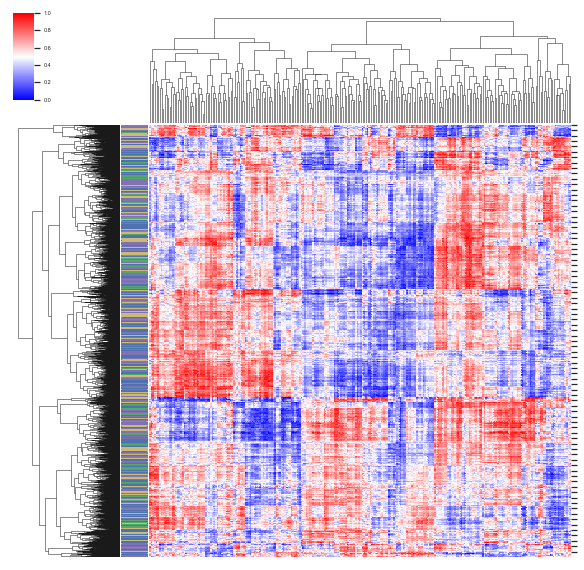

<Figure size 432x288 with 0 Axes>

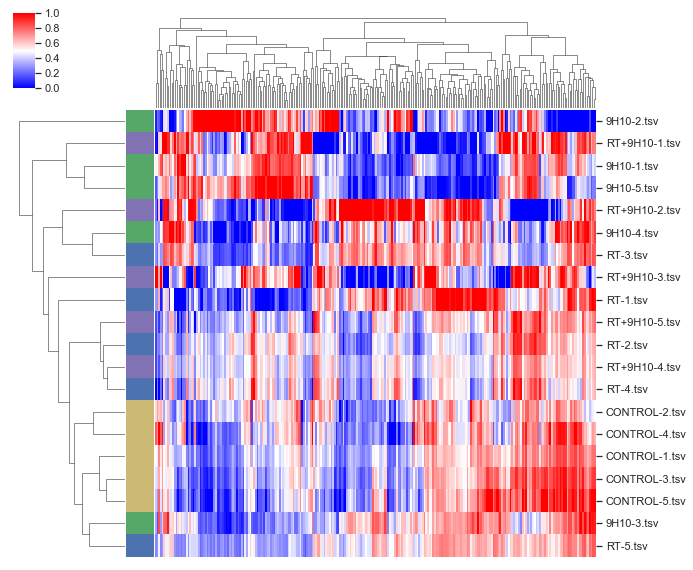

<Figure size 432x288 with 0 Axes>

In [7]:
color_dict = {'Control':'y','RT':'b','9H10':'g','Combo':'m'}
DTCRU.HeatMap_Sequences(filename='Rudqvist_VAE_HM_Sequences.tif',color_dict=color_dict)
DTCRU.HeatMap_Files(filename='Rudqvist_VAE_HM_Files.tif',color_dict=color_dict)

Finally, we can cluster the sequences on their re-representations via heierarchical clustering. The output is a list of dataframes (DFs) in the object that one can visualize. Additionally, by settting the write_to_sheets parameter to True, a folder is generated in the results folder with a csv file for each cluster. 

In [8]:
DTCRU.Cluster(write_to_sheets=True)


Clustering Done


## Supervised Analysis

Supervised analyses can often be more powerful than unsupervised analyses as they can leverage the labels to better drive the learning process. In DeepTCR, we provide two types of supervised analysis approaches. The first is a single-sequence classifier that attempt to classify tCR sequences given a label. For example, this label could be the antigen the sequence targets. The second is s whole-file classifier that attempt to classify an entire file of TCR sequences. For example, this could be a file that comes from a tumor that has undergone a certain kind of immunotherapy.

First, we will import a DeepTCR Supervised Object for which we will run the methods to do these unsupervised analyses:

In [1]:
from DeepTCR.DeepTCR_S import DeepTCR_S

Once again, we will create an object for our supervised analysis.

In [3]:
DTCRS = DeepTCR_S('Rudqvist_S')


### Single Sequence Analysis

First, we will load our data.

In [3]:
DTCRS.Get_Data_SS(directory='Data/Rudqvist/',Load_Prev_Data=False)


Data Loaded


We will then divide out data into Train/Validation/Test Cohorts. The fraction that is set for test_size will be allocated for valid/test cohorts and rest will be used for training. Validation cohort is used to implement an early stopping algorithm.

In [4]:
DTCRS.Get_Train_Valid_Test_SS(test_size=0.25)


Train network.

In [5]:
DTCRS.Train_SS(epochs_min=5, suppress_output = True)


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done Training


After training, we can visualize the ROC curves and the AUC for the respective classes.

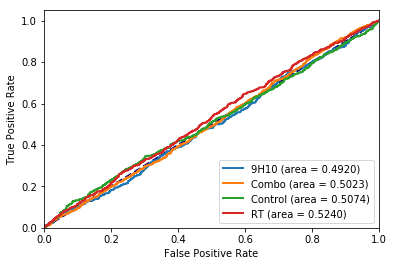

In [6]:
DTCRS.AUC_Curve(show_all=True,filename='Rudqvist_SS')


Following training of the single-sequence classifier, we can query which motifs were used for a given class and are associated with that class of sequences. By calling the method below and specifying the group parameter, we can determine which motifs are associated with the 'Control' mice. After the method is called, a new folder appears underneath the results folder with the motifs that were associated with that cohort. In the folder are fasta files that can be used with a seqlogo creator (https://weblogo.berkeley.edu/logo.cgi) to create visualizations of those motifs. Also, in the object there is a group_features_ss dataframe which contains the top sequences that activated the given enriched motif/feature.

In [15]:
DTCRS.Motif_Identification_SS(group='Control')


Motif Identification Completed


### Whole Sample Analysis

Once again, we load our data.

In [4]:
DTCRS.Get_Data_WF(directory='Data/Rudqvist/',Load_Prev_Data=False)


Data Loaded


To do our training of the whole file classifier, there exists several ways to train the network. The first method is a regular train/valid/test split where we train on a subset of the files and test on the te rest.

In [5]:
DTCRS.Get_Train_Valid_Test_WF(test_size=0.25)
DTCRS.Train_WF(suppress_output = True)


Done Training


In the case where there is a small number of samples, we can also do a Monte-Carlo simulation where we train/test on random selections of the data and do this multiple times to better approximate the predictive signature in the data.

In [6]:
DTCRS.Monte_Carlo_CrossVal(fold=25,test_size=0.25, suppress_output = True)

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Monte Carlo Simulation Completed


We can also do a K-fold Cross-Validation where we divide the data into k-folds and train/test on all folds.

In [8]:
DTCRS.K_Fold_CrossVal(folds=20,suppress_output = True)


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
Done Training
K-fold Cross Validation Completed


Finally, as in the single-sequence classifier, we can assess the predictive power via ROC curves and derive the associated motifs for each class.

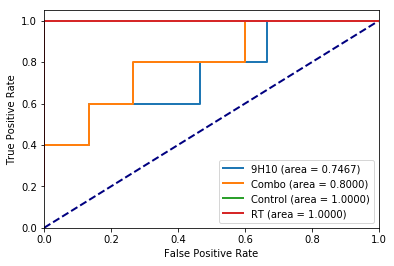

Motif Identification Completed


In [9]:
DTCRS.AUC_Curve(show_all=True,filename='Rudqvist_WF')
DTCRS.Motif_Identification_WF('RT')